# 데이터 EDA

## 패키지 설치, 데이터 불러오기

In [110]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

# 경로 설정
data_path = '../../data'
saved_path = './../saved'
output_path = './../submission'

In [119]:
# 데이터 불러오기
# 시청 시작/종료 데이터
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')

# 구매/검색 데이터
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

# 콘텐츠(아이템) 메타정보 데이터
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

# 유저 프로필 데이터
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

# 제출 파일 데이터
submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

# 이미 제출한 파일?
tem_df = pd.read_csv(os.path.join(output_path, 'submission.csv'), encoding='utf-8')


## 데이터 테이블 이해해보기

### 유저 - 아이템 상호작용 데이터에 대해

In [112]:
def info(table):
    all_nums = table.shape[0]
    item_nums = table['album_id'].nunique()
    user_nums = table['profile_id'].nunique()
    act_value = table['act_target_dtl'][0]
    print(f'테이블 총 길이는 {all_nums}')
    print(f'아이템 개수는 {item_nums}')
    print(f'유저 수는 {user_nums}')
    print(f'act_target_dtl 변수는 {act_value}')
    print('')

print('history_df')
info(history_df)
print('watch_df')
info(watch_df)
print('buy_df')
info(buy_df)
print('search_df')
info(search_df)

print('meta 테이블 아이템 개수는', meta_df['album_id'].nunique())
print('meta_plus 테이블 아이템 개수는', meta_plus_df['album_id'].nunique())
# 767948로 많은 이유가 뭘까??
print('profile 테이블 유저 수는', profile_df['profile_id'].nunique())

history_df
테이블 총 길이는 1005651
아이템 개수는 20695
유저 수는 8311
act_target_dtl 변수는 MKID003

watch_df
테이블 총 길이는 892794
아이템 개수는 20361
유저 수는 7658
act_target_dtl 변수는 MKID049

buy_df
테이블 총 길이는 150
아이템 개수는 126
유저 수는 17
act_target_dtl 변수는 MKID004

search_df
테이블 총 길이는 6474
아이템 개수는 1977
유저 수는 644
act_target_dtl 변수는 MKID017

meta 테이블 아이템 개수는 39875
meta_plus 테이블 아이템 개수는 39875
profile 테이블 유저 수는 8311


1) buy_df, search_df 테이블은 생각보다 크지 않다. 나중에 고려해도 될수도?
2) 기록되어 있는 Item은 2만여개, 실제 meta 아이템은 4만여개. 생각할 여지가 많은 부분.
2-1) 여러 번 리더보드 제출을 통해 경험해야 할 부분. train에 없는 item을 test에 많이 추천해야 하는지?
2-2) 이렇게 되면 유저-아이템간 그래프 관계보다 아이템 내 Context 정보를 이용하는게 좋을지도?
3) profile 유저수는 8311, train 데이터 내 유저 수 또한 8311. 아에 처음 본 유저를 예측하는 것은 아님.

### 메타(아이템)정보에 대해

In [113]:
print(meta_df.shape)
print(meta_plus_df.shape)
print('meta 테이블 아이템 개수는', meta_df['album_id'].nunique())
print('meta_plus 테이블 아이템 개수는', meta_plus_df['album_id'].nunique())

(42602, 16)
(767948, 4)
meta 테이블 아이템 개수는 39875
meta_plus 테이블 아이템 개수는 39875


In [114]:
meta_df.info() # NULL 값이 참 많다. onair_date 변수 또한 무의미할수도.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42602 entries, 0 to 42601
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   album_id     42602 non-null  int64  
 1   title        42602 non-null  object 
 2   sub_title    42602 non-null  object 
 3   genre_large  42602 non-null  object 
 4   genre_mid    42602 non-null  object 
 5   genre_small  13419 non-null  object 
 6   country      33734 non-null  object 
 7   run_time     42602 non-null  int64  
 8   onair_date   5344 non-null   float64
 9   cast_1       27603 non-null  object 
 10  cast_2       22048 non-null  object 
 11  cast_3       16463 non-null  object 
 12  cast_4       12485 non-null  object 
 13  cast_5       6382 non-null   object 
 14  cast_6       2609 non-null   object 
 15  cast_7       762 non-null    object 
dtypes: float64(1), int64(2), object(13)
memory usage: 5.2+ MB


In [115]:
# 앨범은 실제 39875개 존재하지만 meta_df은 42602개 존재
# 왜 수천 개가 늘어났는지 살펴봅시다.
meta_df['album_id'].value_counts()

8231     4
4083     4
4932     4
5314     4
3843     4
        ..
16963    1
32433    1
32434    1
32435    1
11629    1
Name: album_id, Length: 39875, dtype: int64

In [116]:
# sub_title만 다르고 나머지 형태는 일치하는 것이 보이네요.
meta_df[(meta_df['album_id'] == 8231)]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
13526,8231,알록달록 물고기,노래율동,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13527,8231,알록달록 물고기,만 3세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13528,8231,알록달록 물고기,만 4세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13529,8231,알록달록 물고기,트니트니 율동 바다스페셜,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# sub_title을 제외한 뒤 중복을 관찰해보니 정확히 39875개 나왔습니다.
meta_df = meta_df.drop(['sub_title'], axis = 1).drop_duplicates().reset_index(drop = True)
meta_df.shape

(39875, 15)

In [38]:
# 키워드 종류는 특이한게 많다??
print(meta_plus_df['keyword_type'].value_counts())
n = 10
# n개 이하의 개수를 가진 키워드는 몇개나 될까?
print(sum(meta_plus_df['keyword_type'].value_counts() < n))

05010101    32644
05020203    30040
05090806    26135
05090802    23611
05010601    16553
            ...  
05030808        1
05010e03        1
05010910        1
0509071c        1
05040228        1
Name: keyword_type, Length: 1101, dtype: int64
131


### 유저에 대해

In [69]:
history_df.info() # payment 변수 NULL 값이 너무 많다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005651 entries, 0 to 1005650
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   profile_id       1005651 non-null  int64  
 1   ss_id            1005651 non-null  int64  
 2   log_time         1005651 non-null  int64  
 3   act_target_dtl   1005651 non-null  object 
 4   album_id         1005651 non-null  int64  
 5   payment          73486 non-null    float64
 6   continuous_play  1005651 non-null  object 
 7   short_trailer    1005651 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 61.4+ MB


0


<AxesSubplot: >

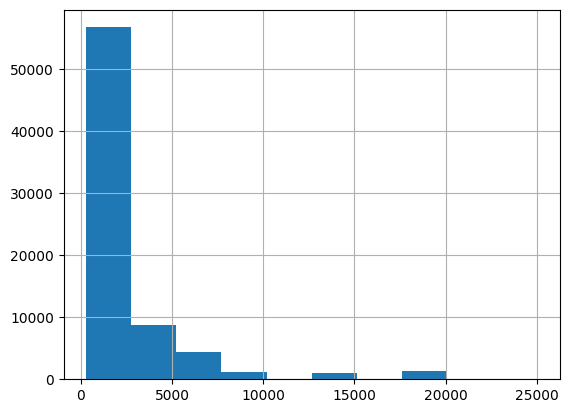

In [70]:
print(sum(history_df['payment'] == 0))
history_df['payment'].hist()

공짜로 구매한 것이 NULL 값으로 취급됬다고 판단.

In [80]:
# 중복기록 제거
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
# 한 유저가 몇개의 컨텐츠를 즐겼는지
user_item_num = data.groupby('profile_id')['album_id'].nunique()

In [99]:
n = 5
all_user = len(user_item_num)
n_lower_user = sum(user_item_num <= n)

print(f'전체 유저 {all_user}명 중 {n}개 이하의 아이템을 기록한 유저가 {n_lower_user}명입니다.')
print(f'submission 파일 길이는 {len(submission_df)}로 출력 데이터는 모든 유저를 포함하고 있습니다.')
# cold start 유저도 생각해볼 필요가 있음.

전체 유저 8311명 중 5개 이하의 아이템을 기록한 유저가 1629명입니다.
submission 파일 길이는 8311로 출력 데이터는 모든 유저를 포함하고 있습니다.


### baseline 모델이 얼마나 다양한 아이템을 추천할까?

In [132]:
_set = set()

for i in range(8311):
    _set.update(eval(tem_df['predicted_list'][i]))

In [146]:
print(len(_set))
print(len(set(history_df['album_id'])))
print(len(set(meta_df['album_id'])))
_set - set(history_df['album_id']) # _set에서 train 데이터를 제외한 값

14165
20695
39875


set()

train 데이터 내 있는 아이템 이외에 아이템은 추천하지 않습니다.

약 2만개 신생 아이템은 추천 받을 기회 조차 없군요.